In [15]:
from yuning_util.dev_mode import DevMode
dev_mode = DevMode('k-seq')
dev_mode.on()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
plt.style.use('seaborn')

# Simulate p0, k, A from parametric distribution

Specifically:

- p0: simulate from 

In [116]:
from k_seq.data.simu import DistGenerators

SEQ_NUM = 1_000
X, y, truth = pool_counts_simulator(pool_size=SEQ_NUM,
                      c_list=[-1, -1, 0.001, 0.001],
                      N_list=[10000, 10000, 10000, 10000],
                      p0=DistGenerators.compo_lognormal(loc=0, scale=0, size=SEQ_NUM),
                      k=DistGenerators.lognormal(c95=[0.1, 100], size=SEQ_NUM),
                      A=DistGenerators.uniform(low=0, high=1, size=SEQ_NUM),
                      reps=3,
                      seed=None)

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


In [117]:
X

,s0-0,s0-1,s0-2,s1-0,s1-1,s1-2,s2-0,s2-1,s2-2,s3-0,s3-1,s3-2
sample,,,,,,,,,,,,
0,13,11,8,9,8,9,1,2,4,5,1,5
1,4,18,12,15,7,7,38,29,31,33,31,19
2,12,8,12,7,8,15,1,0,1,0,1,2
3,10,16,8,13,13,14,16,27,18,13,19,17
4,11,11,10,9,10,10,27,22,29,22,23,23
...,...,...,...,...,...,...,...,...,...,...,...,...
995,11,8,8,7,11,11,1,0,1,1,1,0
996,7,10,11,14,12,9,4,1,3,3,5,2
997,12,13,4,8,6,10,2,2,2,1,2,1


In [187]:
from k_seq.data import simu
reload(simu)

truth = k_seq_dataset_simulator(pool_size=1000,
                                p0=simu.DistGenerators.compo_lognormal,
                                k=sim
                                
                                c_list=None, N_list=None, seed=23)
truth

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


ValueError: Please indicate loc/scale or c95

In [188]:
def gen():
    import numpy as np
    while True:
        yield np.random.random()
        
gengen = gen()

In [206]:
next(gengen)

0.5172978838465893

In [205]:
np.random.seed(23)

# Simulate from data

We simulate pool from estimated data to mimic the actual distribution

- We filtered the sequence by the sequences we can perform classic least squared fitting (that only contains sequences observed in the input pool

In [43]:
from k_seq.data.seq_table import SeqTable
import pandas as pd

byo_doped = SeqTable.load_default_dataset(dataset='byo-doped')
ls_point_est = pd.read_csv('/mnt/storage/projects/k-seq/working/byo_doped/least_square/point-est_bounded_pod_10-21-19/fit_summary.csv', index_col=0)

# survey initial pool composition from byo_doped and add to ls_point_est
counts = byo_doped.table['R0'][ls_point_est.index]
counts = counts.sparse.to_dense()
ls_point_est['counts'] = counts
ls_point_est['p0'] = counts / np.sum(counts)
ls_point_est.describe()

Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo_doped.pkl
Imported!


In [54]:
from k_seq.data.simu import PoolParamSimulator

PoolParamSimulator.sample_from_dataframe(df=ls_point_est, size=1000)

,k,A,p0
ATTACTCTGGGCGTCGAATGA,0.030297,0.030256,1.225997e-07
CCCCATTTCAAGAAATCGGTC,1.201573,1.000000,1.225997e-06
CCACACTTGTAGGAACCGGTC,1745.178422,0.018252,3.064993e-08
CCTCACTTCAGGTAATCCGTC,0.032839,0.031124,6.129985e-08
AAGGTTGCTAATGGTCTCAAA,1.135101,1.000000,3.064993e-08
...,...,...,...
CCTCACTCCAAGCGATCCGTC,0.023573,0.040498,9.194978e-08
CCACACATTTAGCAATAGGTC,107.020230,0.083341,3.064993e-08
CCACGCTTCAAGCAACCGGTT,31.537675,0.009845,1.011448e-06
GTAGTTCGATCAATCGGTCTG,0.018565,0.034220,1.225997e-07


## [Analysis] Caveats of sampling from a heterogenous pool

If not weighting each unique sequences, it will be more likely to sample the low pct seqs.

QUESTION: what does the heterogeneity means here? Entropy?

In [7]:
simu_pool_sizes = [-1, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]
from k_seq.data.simu import PoolParamSimulator

sampled_pool = [ls_point_est if size < 0 else PoolParamSimulator.sample_from_dataframe(df=ls_point_est, size=int(size))
                for size in simu_pool_sizes]

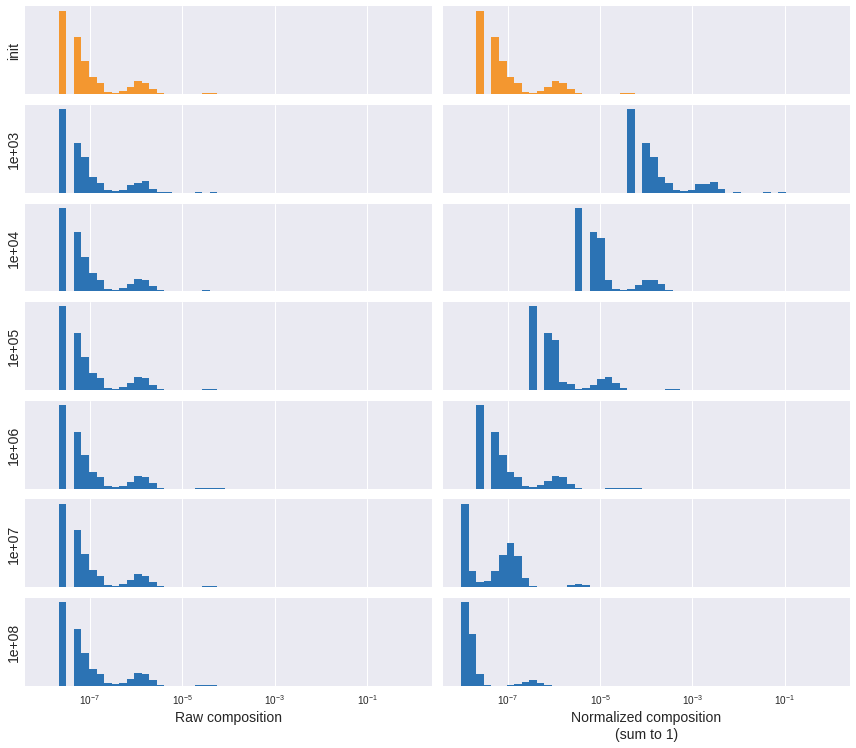

In [20]:
fig, axes = plt.subplots(len(simu_pool_sizes), 2,
                         figsize=[6 * 2, 1.5 * len(simu_pool_sizes)],
                         sharex=True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)

bins = np.logspace(-8, 0, 50)
for ax, sample, size in zip(axes, sampled_pool, simu_pool_sizes):
    ax[0].hist(sample['p0'], bins=bins, color='#F39730' if size < 0 else '#2C73B4')
    ax[0].set_xscale('log')
    ax[0].set_yticks([])
    ax[0].set_ylabel('init' if size <0 else f'{size:1.0e}', fontsize=14)
    ax[1].hist(sample['p0']/sample['p0'].sum(), bins=bins, color='#F39730' if size < 0 else '#2C73B4')
    ax[1].set_xscale('log')
    ax[1].set_yticks([])
axes[-1][0].set_xlabel('Raw composition', fontsize=14)
axes[-1][1].set_xlabel('Normalized composition\n(sum to 1)', fontsize=14)

plt.tight_layout()
plt.show()

In [27]:
def get_entropy(series, normalize=True, base=2):
    if pd.api.types.is_sparse(series):
        series = series.sparse.to_dense()
    series = series / np.sum(series)
    if normalize:
        return -np.sum(series * np.log(series)) / np.log(len(series))
    else:
        return -np.sum(series * np.log(series)) / np.log(base)

In [33]:
entropy_efficiency = [get_entropy(pool['p0'], normalize=True) for pool in sampled_pool]

In [35]:
entropy_efficiency

[0.6483428703023708,
 0.6481022710236064,
 0.5632507455702411,
 0.6721969440908934,
 0.6884432681998506,
 0.7150146921267801,
 0.743030885573317]

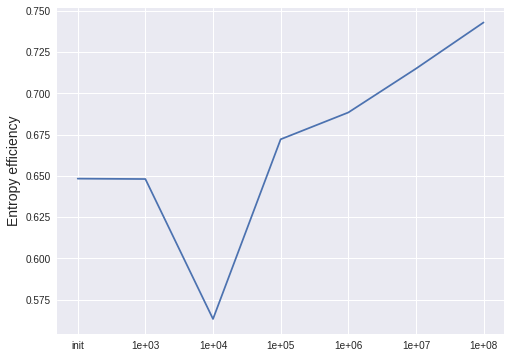

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(np.arange(len(simu_pool_sizes)), entropy_efficiency)
ax.set_xticks(np.arange(len(simu_pool_sizes)))
ax.set_xticklabels(['init' if size < 0 else f'{size:1.0e}' for size in simu_pool_sizes])
ax.set_ylabel('Entropy efficiency', fontsize=14)
plt.show()

## Simulate the pool by sampling with similar size, sequencing depth

In [162]:
UNIQ_SEQ_NUM = int(1e6)

from k_seq.data.simu import PoolParamSimulator

pool_params = PoolParamSimulator.sample_from_dataframe(
    df=ls_point_est[~ls_point_est.isna().any(axis=1)],
    size=UNIQ_SEQ_NUM,
    seed=23)
print(f"Simulated pool contains\n\tUnqiue seqs: {UNIQ_SEQ_NUM:,}\n\tTotal reads: {pool_params['counts'].sum():,}")

Simulated pool contains
	Unqiue seqs: 1,000,000
	Total reads: 37,979,506


/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


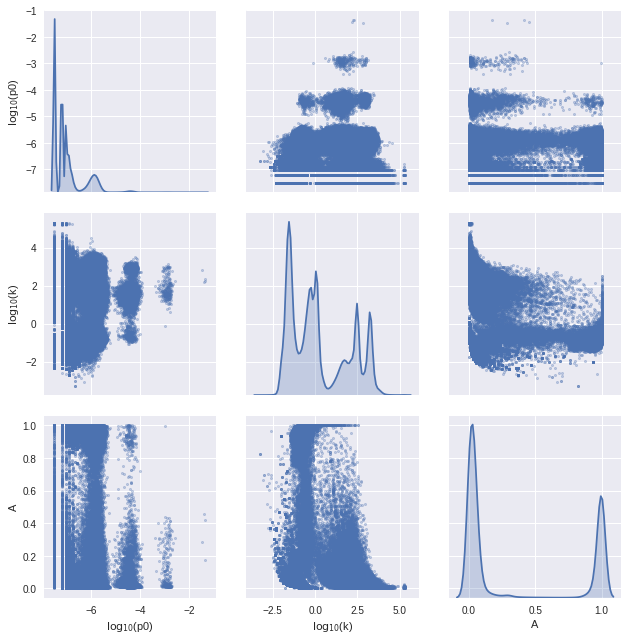

In [164]:
def pairplot(data, vars_name=None, vars_lim=None, vars_log=None, figsize=(3, 3), **kwargs):
    import numpy as np
    if vars_name is None:
        vars_name = list(data.columns)
    else:
        data = data[vars_name]
    
    for var, var_log in zip(vars_name, vars_log):
        if var_log:
            data.loc[:, var] = data[var].apply(np.log10)
            data.rename(columns={var: "$\log_{10}$(%s)" %(var)}, inplace=True)

    return sns.pairplot(data=data, vars=data.columns,
                        markers='o', plot_kws=dict(s=5, edgecolor=None, alpha=0.3),
                        height=figsize[1], aspect=figsize[0]/figsize[1], **kwargs)

pp = pairplot(ls_point_est[~ls_point_est.isna().any(axis=1)], vars_name=['p0', 'k', 'A'], vars_log=[True, True, False], diag_kind='kde')

/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


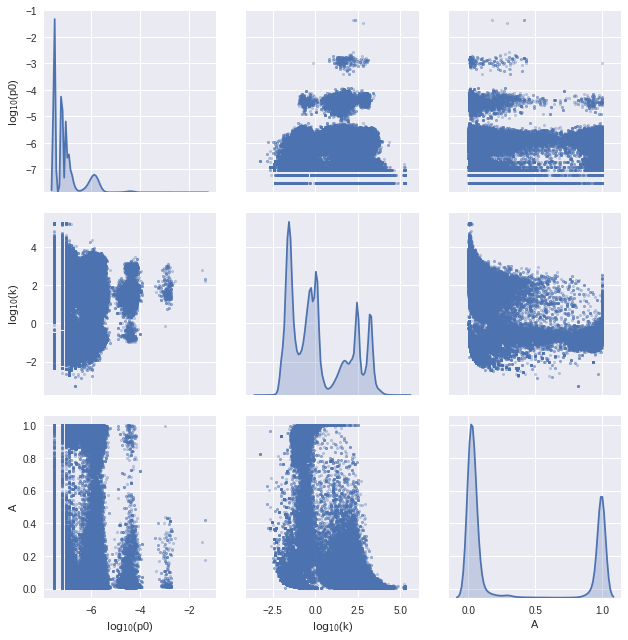

In [165]:
pp_simu = pairplot(pool_params, vars_name=['p0', 'k', 'A'], vars_log=[True, True, False], diag_kind='kde')